# Image Classification - NN

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score
import torch
from typing import Callable, List, Tuple, Any, Dict
import random
import sys
import torch.optim as optim

- Download the [intel image dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) from Kaggle.

## Data Exploration

In [2]:
# the code to load images is a modified version of code provided in the assignment instructions
IMGSIZE = (128, 128)
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
path_prefix = "../EP_Datasets/intel-img-data/"
x_train, y_train, x_test, y_test = [], [], [], []
for label in labels:
    train_path = path_prefix + '/seg_train/seg_train/' + label
    test_path = path_prefix + '/seg_test/seg_test/' + label
    for f in sorted([_ for _ in os.listdir(train_path) if _.lower().endswith('.jpg')]):
        x_train += [cv2.resize(cv2.imread(os.path.join(train_path,f)), IMGSIZE)]
        y_train += [labels.index(label)]
    for f in sorted([_ for _ in os.listdir(test_path) if _.lower().endswith('.jpg')]):
        x_test += [cv2.resize(cv2.imread(os.path.join(test_path,f)), IMGSIZE)]
        y_test += [labels.index(label)]

# convert all images from BGR to RGB
x_train_rgb = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in x_train]
x_test_rgb = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in x_test]

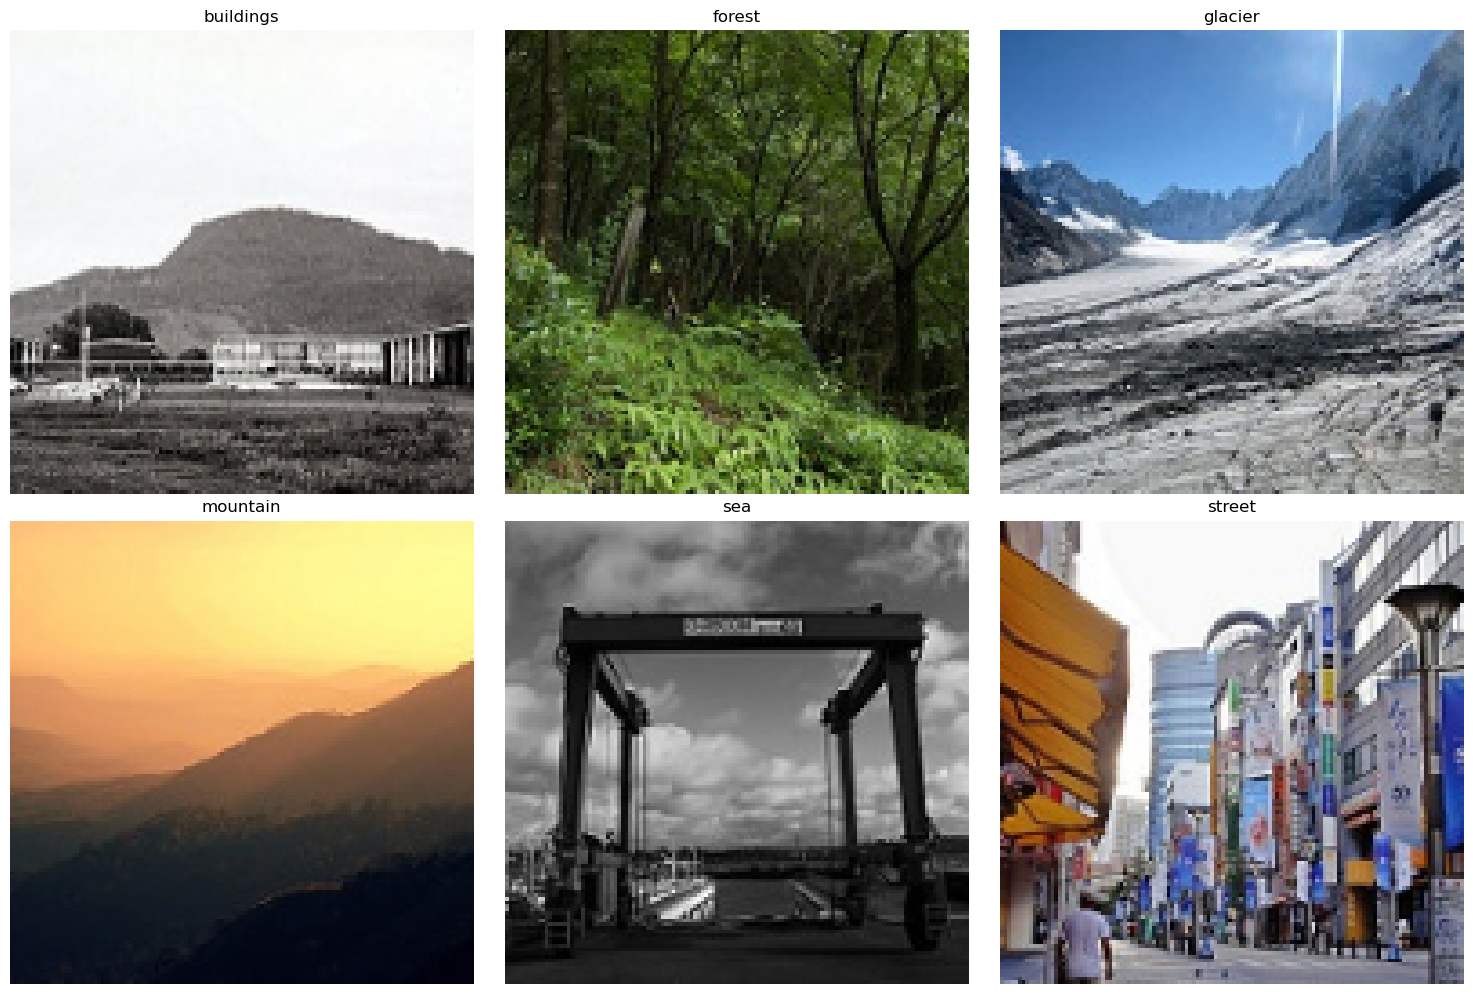

In [3]:
# display one image from each class in the training set
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for i, label in enumerate(labels):
    # find the first occurrence of the label in y_train
    index = y_train.index(i)
    # get the corresponding image from x_train
    img = x_train_rgb[index]

    # display the image
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

In [4]:
# determine the number of color channels
x_train_rgb[0].shape

(128, 128, 3)

In [5]:
x_test_rgb[0].shape

(128, 128, 3)

Based on the shape of the training and testing images, there are 3 color channels in the images.

## Data Preprocessing

In [6]:
# convert to numpy arrays
x_train = np.array(x_train_rgb)
y_train = np.array(y_train)
x_test = np.array(x_test_rgb)
y_test = np.array(y_test)

# confirm shape
print(f"The shape of the training numpy array is: {x_train.shape}")
print(f"The shape of the testing numpy array is: {x_test.shape}")

The shape of the training numpy array is: (14034, 128, 128, 3)
The shape of the testing numpy array is: (3000, 128, 128, 3)


In [7]:
# rescale the image to [0-1]
x_train_normalized = x_train.astype(np.float32) / 255.0
x_test_normalized = x_test.astype(np.float32) / 255.0

In [8]:
# confirm that rescaling worked
print("Before normalization:")
print(f"Min value (x_train): {x_train.min()}, Max value (x_train): {x_train.max()}")
print(f"Min value (x_test): {x_test.min()}, Max value (x_test): {x_test.max()}")

print("\nAfter normalization:")
print(f"Min value (x_train_normalized): {x_train_normalized.min()}, Max value (x_train_normalized): {x_train_normalized.max()}")
print(f"Min value (x_test_normalized): {x_test_normalized.min()}, Max value (x_test_normalized): {x_test_normalized.max()}")

Before normalization:
Min value (x_train): 0, Max value (x_train): 255
Min value (x_test): 0, Max value (x_test): 255

After normalization:
Min value (x_train_normalized): 0.0, Max value (x_train_normalized): 1.0
Min value (x_test_normalized): 0.0, Max value (x_test_normalized): 1.0


## Model Training

Reminder, you have to convert the 3D image (including the color channel) to a linear vector
in case you use fully connected layers at the input, i.e.

`_X = torch.flatten(_X, start_dim=1)`

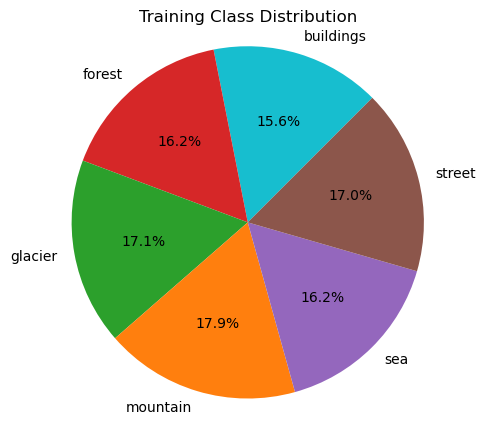

In [9]:
# show the class distribution to determine the evaluation metric
class_counts = Counter(y_train)
hd_dist = [class_counts[i] for i in range(len(labels))]
fig = plt.figure(figsize=(5, 5))
plt.pie(hd_dist, labels=labels, autopct='%1.1f%%', startangle=45, colors=['#17becf', '#d62728', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b'])
plt.axis('equal')
plt.title('Training Class Distribution')
plt.show()

The class distribution is relatively equal for all classes. The following evaluation will use accuracy as the evaluation metric. 

In [10]:
class PyTorchNN:
    def __init__(self, n_features, n_labels, model, epochs=500, with_logs=True, minibatch_size=100):
        self.device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
        self.model = model.to(self.device)
        self.optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.with_logs = with_logs
    
    # reset weights before training
    def _reset(self):
        for m in self.model.modules():
            if isinstance(m, torch.nn.Linear):
                 m.reset_parameters()
                    
    def fit(self, x_train, y_train):
        # reset model weights before training
        self._reset()
        x_train_tensor = torch.tensor(x_train).float().to(self.device)
        y_train_tensor = torch.tensor(y_train).long().to(self.device)

        # flatten the image data
        x_train_tensor = torch.flatten(x_train_tensor, start_dim=1)

        for epoch in range(self.epochs):
            total_loss = 0.0
            total_batches = 0
            indices = np.arange(x_train_tensor.shape[0])
            random.shuffle(indices)  # shuffle the data each epoch
            # pass data in batches
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                self.optimizer.zero_grad()
                
                # forward pass
                outputs = self.model(x_train_tensor[batch_idx])
                
                loss = self.loss_function(outputs, y_train_tensor[batch_idx])
    
                # backward pass
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                total_batches += 1
            # calculate avg loss for each epoch
            if self.with_logs:
                sys.stderr.write(f"\rIteration {epoch+1}/{self.epochs}  Loss: {total_loss/total_batches:6.5f}")
                sys.stderr.flush()
                
    def predict(self, x_test):
        # set model to eval mode
        self.model.eval()
        x_test_tensor = torch.tensor(x_test).float().to(self.device)
        # flatten the image data
        x_test_tensor = torch.flatten(x_test_tensor, start_dim=1)
        # get predictions
        with torch.no_grad():
            outputs = self.model(x_test_tensor)
            _, predicted = torch.max(outputs.data, 1)

        return predicted.cpu().numpy()

    def evaluate(self, x_test, y_test):
        # get predictions and calculate accuracy
        predicted = self.predict(x_test)
        accuracy = accuracy_score(y_test, predicted)
        print(f'{round(accuracy * 100, 2)}%')

In [11]:
# the number of features is the number of features for the flattened image data (height * width * channels)
n_features = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
n_labels = len(labels)

model = torch.nn.Sequential(
            torch.nn.Linear(n_features, 50),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(50, 50),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(50, n_labels)
        )

# initialize model and fit
model = PyTorchNN(n_features=n_features, n_labels=n_labels, model=model, epochs=200)
model.fit(x_train_normalized, y_train)

Iteration 200/200  Loss: 0.78686

In [12]:
# get reclassification metrics
print("Training Accuracy:")
model.evaluate(x_train_normalized, np.array(y_train))

Training Accuracy:
76.15%


In [13]:
# get test accuracy
print("\nTest Accuracy:")
model.evaluate(x_test_normalized, np.array(y_test))


Test Accuracy:
55.07%


The model above did not perform well on the computer vision problem. The following section outlines ways to improve this neural network for image classification tasks. 

## Model Optimization (See the Image-Classification-CNN notebook for the improved model)

A convolutional neural network (CNN) could improve performance for the image classification problem. CNNs achieve high performance for computer vision problems by extracting meaningful features in the convolutional layers and reducing dimensionality in the pooling layers. Parameter sharing and sparse connectivity between layers are other characteristics of CNNS that provide value to image classification tasks [1]. These characteristics reduce the number of parameters (weights) in the network and improve the network's ability to capture distinct pixels in an image. 

The following steps are required to turn the network above into a convolutional neural network:

1. The class takes the model as a parameter. Therefore, define a new model with convolutional and max pooling layers before the fully connected layers.
2. Remove the flattening operation in `model.fit()` because the input should only be flattened for the fully connected layers. The flattening step can be added as a layer before the first fully connected layer in the model definition.
3. The `_reset()` method to reset weights before training should be modified to check for convolutional layers and reset those weight differently than the linear layers.
3. Start by evaluating a simple CNN model and add more convolutional or fully connected layers if needed.
4. Tune model hyperparameters as needed and apply dropout if the model is overfitting.

References

[1] S. Raschka and V. Mijalili, Machine Learning in Python, 3rd Edition,Packt Publishing, 2019.
